## Problem definition: Simple classification of Brain images into MRI vs PET


In this jupyter notebook, you will learn to build a basic classification model using convolutional neural netowrks to classify  medical images generated from two different modalities namely PET and MRI. We will be using the PyTorch API for the classification.

In order to enable ease of access we have converted all the DICOM formatted images into JPEG format and randomly sorted them into training and test set.

## Some basics on classification problems
1. Classification problems can be set-up as a binary (eg. cat vs dogs) or multi-class (eg. cat, dog, chicken and turtle) classification.
2. In the current scienario we are doing a **Binary** classification as to whether an image is a MRI image or PET image.
3. In classification problems you should pay attention to the perfromance metrics such as Accuracy, area under reciever operating curve (AUROC) and area under precision recall curve (AUPRC). These metrics help us determine if our model is doing what we intended it for.
4. The above metrics are calculated based on if the lables are True positve/negative (TP/N) and Fasle postive/negative (FP/N). Your actual data only has True positives and negatives. False predictions are done by the model.
5. Depending on the context of the problem we might pick which perfromance metric to pay attention to. For instance, if we are interested in predicting if a person has cancer or not -based on health record, it is very important that we dont miss someone with cancer (True Negative) than predicting a healthy person as cancerous (False Positve).
Let's define it more in numbers: Let's say we would like to predict if a person has cancer or not based on health record. And you are given 1000 data points to train with. Assume only 30 people in the data do actually have cancer. i.e. 30 TP and 970 TN, if we predict one of the 970 as having cancer it is considered False Positive (FP). We are more interested in finding people who have cancer over misclassifications and therefore we care more about the accuracy of predicting the one class over the other.
6. Most classification problems are set up similar to the example above. Notice we have data more on the non-cancerous people than cancerous one. This is called a class imbalance. When we have such a class imbalance it is important to pay attention to how we define the problem.

## Let's continue with the notebook we will lean more on the way.

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, datasets
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import glob as gb
import pandas as pd
import os
from tqdm import tqdm
from sklearn.metrics import roc_auc_score

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as img
import matplotlib as mpl

In [6]:
!apt-get update -y && apt-get install -y fuse lsb-release; \
    curl -L -O https://github.com/GoogleCloudPlatform/gcsfuse/releases/download/v1.4.0/gcsfuse_1.4.0_amd64.deb; \
    dpkg --install gcsfuse_1.4.0_amd64.deb; \
    apt-get update; \
    apt-get clean;

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:5 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 http://security.ubuntu.com/ubuntu jammy-security/restricted amd64 Packages [3,612 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [2,609 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,526 kB]
Get:13 http://archive.ubuntu.com/

In [7]:
from google.colab import auth
auth.authenticate_user()

In [8]:
project_id = 'sfsu-378805'
bucket_name = 'csc-509-image-files'
!gcloud config set project {project_id}

Updated property [core/project].


In [9]:
!gsutil ls

gs://csc-509-image-files/


In [10]:
!mkdir images

In [11]:
!gcsfuse --implicit-dirs csc-509-image-files images

{"time":"14/02/2025 12:38:29.589157","severity":"INFO","msg":"Start gcsfuse/1.4.0 (Go version go1.21.5) for app \"\" using mount point: /content/images\n"}


In [12]:
!ls images/

Archive				Module0_UPENNGBM  Module1_BraTS.tar.bz2  Module2_ADNI_New
Module0_DataCuration		Module1_ADNI	  Module1_PET
Module0_MRI_PET_Classification	Module1_BraTS	  Module2_ADNI


In [13]:
train= '/content/images/Module0_MRI_PET_Classification/TRAIN/'
test = '/content/images/Module0_MRI_PET_Classification/TEST/'

Lets check how many images there are under each label in training and validation sets

In [14]:
num_MRI_train_pts = len(gb.glob(train+'MRI/*.jpg'))
num_MRI_test_pts = len(gb.glob(test+'MRI/*.jpg'))
print('There are {} MRI images in the training folder'.format(num_MRI_train_pts)+'\n'+
      'and {} in the test folder'.format(num_MRI_test_pts))


num_PET_train_pts = len(gb.glob(train+'PET/*.jpg'))
num_PET_test_pts = len(gb.glob(test+'PET/*.jpg'))
print('There are {} PET images in the training folder'.format(num_PET_train_pts)+'\n'+
      'and {} images in the test folder'.format(num_PET_test_pts))

There are 10715 MRI images in the training folder
and 1122 in the test folder
There are 1155 PET images in the training folder
and 130 images in the test folder


As you can see there is a large class imbalance, we have more MRI images than we have PET images. These images are in gray scale and have different patient data, let take a look at few of training images. Note for every 1 PET image we have about 10 MRI images. Our model then can easily be skewed to just learn how to identify MRI images. And if our goal is actully to get data from PET images then the model would not be very helpful. In such a scienario we care more about the minor class than the majority class. Below let's define a function for plotting the images in the grid.

# Starting to deal with the data and code the basic data handlers in pytorch!

In [15]:
torch.manual_seed(0) ## Setting the manual seed for reproducibility

In [16]:
# Lets Randomly downsample the MRI data such that we still maintain the class
# imbalance but the ratio is closer to 1:1 MRI:PET
mri_train = list(np.random.choice(gb.glob(train+'MRI/*.jpg'),1200, replace=False))
pet_train = gb.glob(train+'PET/*.jpg')
mri_test = list(np.random.choice(gb.glob(test+'MRI/*.jpg'),150,replace=False))
pet_test = gb.glob(test+'PET/*.jpg')


train_files = mri_train.copy()
train_files.extend(pet_train)

test_files = mri_test.copy()
test_files.extend(pet_test)

train_labels = ['MRI'] * len(mri_train)
train_labels.extend(['PET'] * len(pet_train))

test_labels = ['MRI'] * len(mri_test)
test_labels.extend(['PET'] * len(pet_test))

#We will create a train and test data frames
train_df = pd.DataFrame({'filename': train_files,
              'label': train_labels})
test_df = pd.DataFrame({'filename': test_files,
              'label': test_labels})



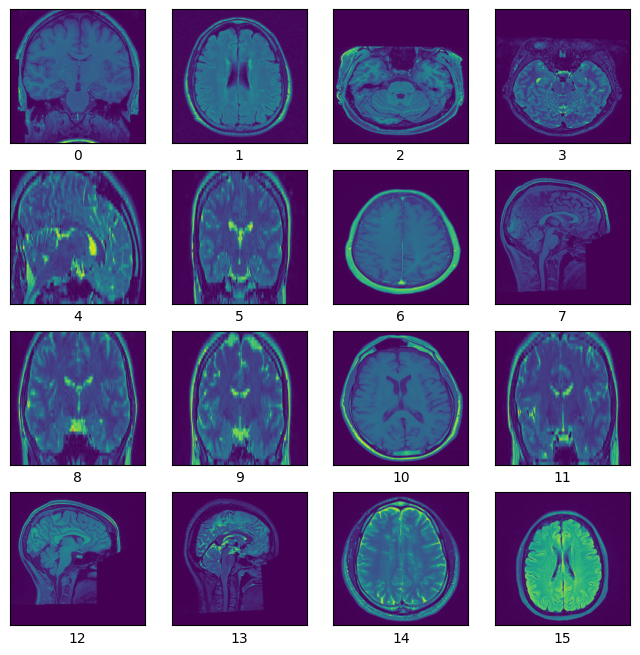

In [17]:
def plot_grid(n,files):
  # takes argument n of the n x n grid and the list of files
  plt.figure(figsize=(8,8))
  for i in range(n*n):
    plt.subplot(n,n,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #MRI images
    idx=np.random.randint(len(files))
    plt.imshow(img.imread(files[idx]),aspect='auto')
    plt.xlabel(i)
  plt.show()


# lets plot mri_train
plot_grid(4,mri_train)

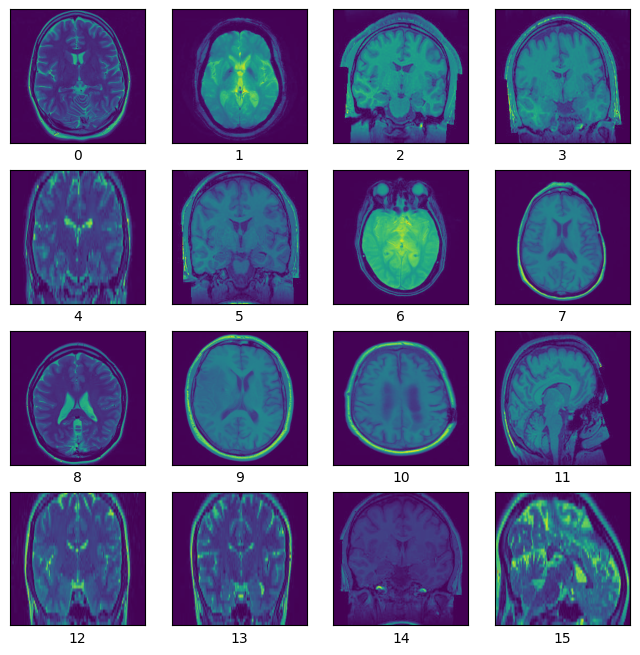

In [18]:
# lets plot mri_train
plot_grid(4,mri_train)

Lets look at the test set as well. Note the test and train data have been downloaded from ADNI dataset:
- http://adni.loni.usc.edu/
- https://fastmri.med.nyu.edu/
- https://openneuro.org/


In future if you'd like to get medical imaging data you use the following sources:

- https://fastmri.med.nyu.edu/
- https://openneuro.org/
- https://www.cancerimagingarchive.net/
- https://www.aylward.org/notes/open-access-medical-image-repositories

Lets look at the PET image training set likewike

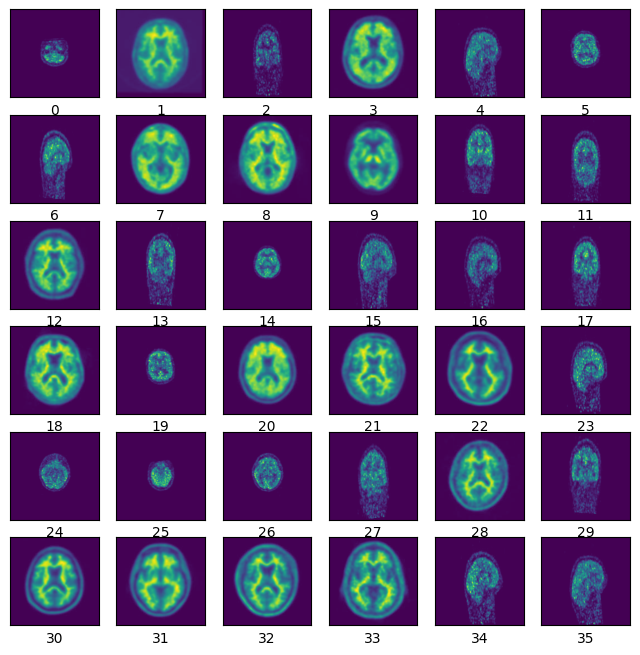

In [19]:
plot_grid(6,pet_train)

As you can see the images in the MRI data and the PET dataset are quite distinct from each other. As we learned earlier in the lecture 2 and 3 there are fundemental differences between what is getting imaged and how it is captured/processed. We want the CNN to learn this(well sort of).

**Look at the PET test data on your own in the below code block**

In [20]:
## Add in your own code here

Next, let's load these images off disk using PyTorch's torchvision library. The ImageFolder class can automatically infer the data classes based on the subfolders in the directory. In practice, data augmentation can be performed using torchvision.transforms, but we will not be utilizing this feature at the moment.

Note the transforms.Resize parameter is set to 128x128, which means we are resizing all the images to this resolution. This matches the dimensions of the first layer in your CNN. Adjusting this parameter could affect training speed, but it's recommended to keep it consistent with your model architecture.

We will manually split the images in the training folder into a 70% training set and a 30% validation set.

## Image Datasets

One of the key concepts in PyTorch is being able to create a custom image dataset, which is a subclass of the Dataset class in Pytorch. It is easy to configure to your needs.



In [21]:
# Define a custom dataset
class CustomImageDataset(Dataset):
    def __init__(self, dataframe, classes, transform=None):
        self.dataframe = dataframe
        self.classes = classes
        self.transform = transform
        self.class_to_idx = {cls: idx for idx, cls in enumerate(classes)}

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['filename']
        label = self.dataframe.iloc[idx]['label']
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label_idx = self.class_to_idx[label]
        return image, label_idx

## Image Transformations

You can easily define image trasnformations that you want your images to have on the fly using the pytorch transforms class, as you can see below:

In [22]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),
#    transforms.RandomCrop(128),
    transforms.ToTensor(),
    # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  ToTensor() automatically normalizes the images between 0 and 1. This could be another normalization strategy
])

Similarly lets create test and validation set. This is the 30% subset of the training data and you will use the same data generator.

Once you finish going through this notebook: **As a homework play around with a 60/40 50/50 spilt. Notice the seed parameter it is included to improve the reproducablity of the training and validation split. If you dont specify it the code will pick a random number and everytime you run this it will give you a different result.**

In [23]:
print(train_df.shape)
train_df.head(1)

(2355, 2)


,filename,label
0,/content/images/Module0_MRI_PET_Classification...,MRI


In [24]:
train_df.label.value_counts()

,count
label,
MRI,1200
PET,1155


In [26]:
train_df.shape

(2355, 2)

In [28]:
tmp_train_df = train_df.sample(1648)
train_indices = tmp_train_df.index

In [30]:
tmp_train_df.shape

(1648, 2)

In [29]:
val_df = train_df.drop(train_indices)

In [31]:
val_df.shape

(707, 2)

In [32]:
train_df = tmp_train_df

In [33]:
train_df.shape, val_df.shape

((1648, 2), (707, 2))

In [35]:
train_df.label.value_counts()

,count
label,
MRI,831
PET,817


In [36]:
val_df.label.value_counts()

,count
label,
MRI,369
PET,338


In [37]:
# Create dataset
train_dataset = CustomImageDataset(dataframe=train_df, classes=['MRI', 'PET'], transform=transform)
val_dataset = CustomImageDataset(dataframe=val_df, classes=['MRI', 'PET'], transform=transform)



In [38]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Finally we need an the idependent test set that is not used in training or validation. **!!! Very important in the test data make sure shuffle=False --- if not you will get spurious confusion matrix !!!**

In [39]:
print(test_df.shape)
test_df.head(1)

(280, 2)


,filename,label
0,/content/images/Module0_MRI_PET_Classification...,MRI


In [40]:
test_dataset = CustomImageDataset(dataframe=test_df, classes=['MRI', 'PET'], transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(test_loader.dataset.dataframe.shape)

(280, 2)


In [ ]:
x_test, y_test = next(iter(train_loader))
first_image = x_test[0, :, :, :]

In [55]:
x_test.shape

torch.Size([32, 3, 128, 128])

In [56]:
first_image.min(), first_image.max()

(tensor(0.), tensor(0.8471))

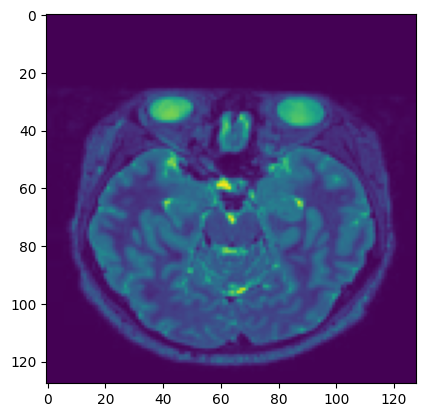

In [57]:
plt.imshow(first_image.numpy()[1,:,:])

In [58]:

y_test.shape

torch.Size([32])

In [59]:
y_test[0]

tensor(0)

The pixel values range from 0-1 so the pixels are indeed normalized. Let's take a look at how the class label for the images are stored. As you can see below the label is a 1D numpy array with two columns each corresponding to the truth value of the class i.e. `[1.,0.] `represents the image is a MRI and `[0.,1.]` represents the image is a PET image. This in ML parlance is known as one-hot enncoding. The label is a vector where values are zero for all classes except the one to which the sample belongs to. This is very convinient to use even in multi-class classifier tasks.

In [60]:
print(y_test)
print(len(y_test))

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])
32


Let's take a look at the images from the keras imagedatagenerator with their lables. I have a dictionary mapped with the label names for clarity. Recall that we read the data into keras in batches of 32 images.

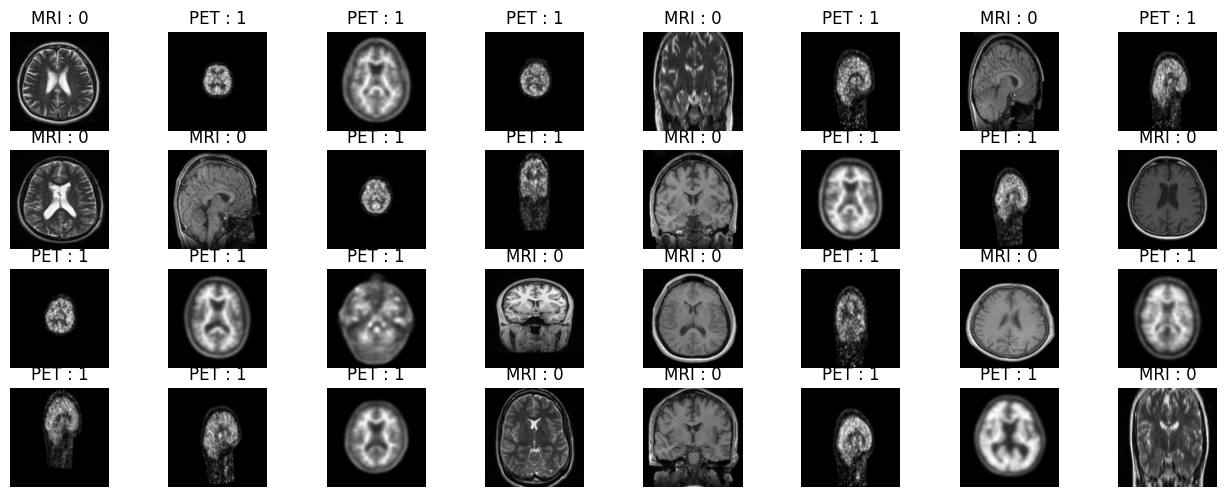

In [ ]:
# Retrieve a single batch from the DataLoader
data_iter = iter(train_loader)
image_batch, labels_batch = next(data_iter)

# Define the dictionary for label names
label_dict = {0: 'MRI', 1: 'PET'}  # Adjust according to your class indices

# Plot the images
plt.figure(figsize=(16, 9))
k = 1
for i in range(len(image_batch)):
    ax = plt.subplot(6, 8, k)
    # Convert the image tensor to a numpy array and scale to [0, 1]
    img = image_batch[i].permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1] for display
    plt.imshow(img)
    plt.title(f"{label_dict[labels_batch[i].item()]} : {labels_batch[i].item()}")
    plt.axis("off")
    k += 1

plt.show()

In [ ]:
print(image_batch.shape)
print(labels_batch.shape)

torch.Size([32, 3, 128, 128])
torch.Size([32])


# Modeling time!

Let's continue with the model...

In [61]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 16 *16, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc_layers(x)
        return x

model = CNNModel()

Lets look at the summary of the model we specified.

In [ ]:
print(model)

CNNModel(
  (conv_layers): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=65536, out_features=32, bias=True)
    (2): ReLU()
    (3): Linear(in_features=32, out_features=2, bias=True)
    (4): Softmax(dim=1)
  )
)


# Implement the training loop below

In [ ]:
def run_epoch(model, data_loader, criterion, optimizer, device, train=True):
    if train:
        model.train()
    else:
        model.eval()

    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    all_labels = []
    all_probs = []

    for images, labels in tqdm(data_loader, desc='Training' if train else 'Validation', leave=False):
        images, labels = images.to(device), labels.to(device)

        if train:
            optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        if train:
            loss.backward()
            optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

        # Store probabilities for AUC
        probs = nn.functional.softmax(outputs, dim=1)[:, 1]
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs.detach().cpu().numpy())  # Detach before converting to numpy

    epoch_loss = running_loss / len(data_loader)
    epoch_accuracy = correct_predictions / total_predictions
    epoch_auc = roc_auc_score(all_labels, all_probs)
    return epoch_loss, epoch_accuracy, epoch_auc


In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=5, learning_rate=0.001, use_gpu=False):
    device = torch.device('cuda' if use_gpu and torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    metrics = {'epoch': [], 'train_loss': [], 'train_accuracy': [], 'train_auc': [],
               'val_loss': [], 'val_accuracy': [], 'val_auc': []}

    for epoch in range(num_epochs):
        train_loss, train_accuracy, train_auc = run_epoch(model, train_loader, criterion, optimizer, device, train=True)
        val_loss, val_accuracy, val_auc = run_epoch(model, val_loader, criterion, optimizer, device, train=False)

        metrics['epoch'].append(epoch + 1)
        metrics['train_loss'].append(train_loss)
        metrics['train_accuracy'].append(train_accuracy)
        metrics['train_auc'].append(train_auc)
        metrics['val_loss'].append(val_loss)
        metrics['val_accuracy'].append(val_accuracy)
        metrics['val_auc'].append(val_auc)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
              f"Train AUC: {train_auc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}, Val AUC: {val_auc:.4f}")

    metrics_df = pd.DataFrame(metrics)
    return metrics_df

In [ ]:
# Assuming 'model', 'train_loader', and 'val_loader' are defined elsewhere
metrics_df = train_model(model, train_loader, val_loader, use_gpu=True, num_epochs = 1)


Epoch 1/1, Train Loss: 0.3158, Train Acc: 0.9970, Train AUC: 0.9993, Val Loss: 0.3169, Val Acc: 0.9958, Val AUC: 1.0000
   epoch  train_loss  train_accuracy  train_auc  val_loss  val_accuracy  \
0      1    0.315773        0.996966   0.999331  0.316899      0.995757   

    val_auc  
0  0.999984  


In [ ]:
metrics_df

,epoch,train_loss,train_accuracy,train_auc,val_loss,val_accuracy,val_auc
0,1,0.315773,0.996966,0.999331,0.316899,0.995757,0.999984
